# 1. **Develop solution:**  Scene Change Detection

## 1.1. Introduction

## 1.2.  Install the modeling requirements and libraries

First, we'll need to **install some libraries** that are not part of our container image. Normally, **Red Hat OpenShift Data Science** or **Red Hat Open Data Hub** is already taking care of this for you, based on what it detects in the code. **Red Hat OpenShift Data Science** or **Red Hat Open Data Hub** will reinstall all those libraries for you every time you launch the notebook!

In case you're using this notebook in a different environment, or just to make sure everything is ready, you can run the following cell to install  Keras (an abstraction layer over Tensorflow).

In [ ]:
%pip install -r requirements1.txt 

## 1.3.  Importing the needed libraries and packages
Of course, we'll need to import various packages. They are either built in the notebook image you are running, or have been installed in the previous step.

In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests
from src.dataloading.read_dataset import readData
from src.features.data_preprocessing import preprocessData
from src.visualization.visualize import visualizeData
from src.modules.build_model import buildModel
from src.modules.train_model import  trainModel,MLflow
from src.modules.predict_model import predictor
from src.hyper_parameters.hps import get_hyper_paras
# from src.github_commands.git_utils import gitCommands
from src.deploy_app.deploy import deployApplication



import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow import keras
from tensorflow.keras import layers
import mlflow
import warnings
import numpy as np
from minio import Minio
import zipfile


## 1.4. Initialize some hyper-parameters

In [2]:
SPLITE_RATE, OUTPUT_FEATURE_NAME, BATCH_SIZE, IMAGE_SIZE, INPUT_SHAPE, DROP_OUT_RATE, EPOCHS, SEED, TRAIN_DATA_FLAG, FINE_TUNE_FLAG = get_hyper_paras()
SPLITE_RATE, OUTPUT_FEATURE_NAME, BATCH_SIZE, IMAGE_SIZE, INPUT_SHAPE, DROP_OUT_RATE, EPOCHS, SEED, TRAIN_DATA_FLAG, FINE_TUNE_FLAG

(0.2,
 ['Background', 'Person', 'MidFinger'],
 32,
 (256, 256),
 (256, 256, 3),
 0.2,
 3,
 100,
 True,
 False)

### 1.4.1. Define a client to read from Minio S3 Bucket

In [3]:
def get_s3_server():
    minioClient = Minio(os.environ['MLFLOW_S3_ENDPOINT'],
                    access_key=os.environ['AWS_ACCESS_KEY_ID'],
                    secret_key=os.environ['AWS_SECRET_ACCESS_KEY'],
                    secure=False)

    return minioClient
client = get_s3_server()

### 1.4.2. SetUp MLFlow to track the model

In [4]:
mlflow = MLflow(mlflow).SetUp_Mlflow()

## 1.5. Reading the  Dataset


In [5]:
train_ds, val_ds, test_ds, num_classes = readData(dataPath = os.environ['DATA_PATH'],imageSize = IMAGE_SIZE, batchSize = BATCH_SIZE, seed = SEED  ).generateData()

Found 2585 files belonging to 3 classes.
Using 2068 files for training.
Found 2585 files belonging to 3 classes.
Using 517 files for validation.
Found 2585 files belonging to 3 classes.
Using 517 files for validation.


## 1.6.  Data Preprocessing

We need to resize the data to make them ready for feeing to our model

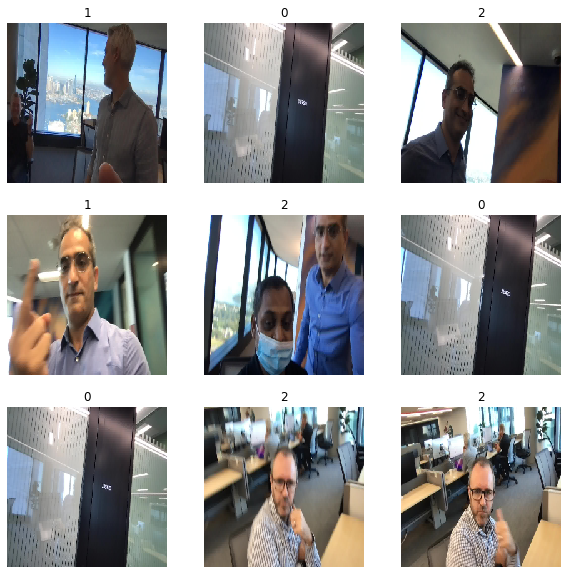

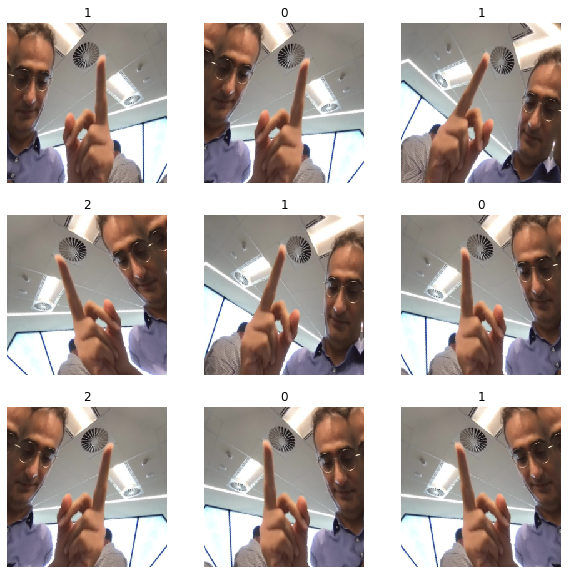

In [6]:
train_ds, val_ds, test_ds, data_augmentation  = preprocessData(trainDs = train_ds,testDs = test_ds,valDs = val_ds,numClasses = num_classes,augFlag=True,height=IMAGE_SIZE[0],width=IMAGE_SIZE[1],batchSize = BATCH_SIZE).dataPreProcessing()

In [7]:
train_ds

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 3)), types: (tf.float32, tf.float32)>

## 1.7.  Design and compile the model 

In [8]:
clf = buildModel(dataAugmentation = data_augmentation, inputShape=INPUT_SHAPE, numClasses=num_classes, topDropoutRate=DROP_OUT_RATE).setupModel()
# clf.summary()

## 1.8.  Training the Model

In [9]:
clf = trainModel(model = clf, trainDs = train_ds, valDs = val_ds, batchSize=32, epochs=3, mlflow=mlflow).ModelTraining()


Epoch 1/3
65/65 [==============================] - 30s 270ms/step - loss: 0.3847 - accuracy: 0.8622 - val_loss: 0.0563 - val_accuracy: 0.9807
Epoch 2/3
65/65 [==============================] - 15s 221ms/step - loss: 0.0197 - accuracy: 0.9938 - val_loss: 0.1029 - val_accuracy: 0.9613
Epoch 3/3
65/65 [==============================] - 15s 223ms/step - loss: 0.0328 - accuracy: 0.9892 - val_loss: 4.6659 - val_accuracy: 0.4952


2022/05/27 02:07:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'PrefetchDataset' object has no attribute '_batch_size'


# 2. **Validate solution based on validation data**  

In [ ]:
predictor(model = clf,data=test, modelType=model_Type).predict()

In [ ]:
os.system('rm -rf ' +os.environ['DATA_PATH'])

# 3. **Deploy solution as an app with seldon** 

In [ ]:
deployApplication().deployApp()

# 4. **Test the Credit Fraud Detection app** 

## 4.1. Get the app route

In [ ]:
my_route = 'http://model-1-pred-demo-fmv3.apps.dbs-indo-1.apac-1.rht-labs.com/api/v1.0/predictions'

## 4.2. Read the test data 

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
im = Image.open("sample.jpg")
img = np.asarray(im)
plt.imshow(img)
plt.show()

## 4.3. Make a decision based on input data

In [ ]:

import base64
import requests
from json import dumps
my_image = 'sample.jpg'
with open(my_image, "rb") as image_file:
    encoded_image = base64.b64encode(image_file.read()).decode('utf-8')

content = {"data":
          {
                "names":
                    ["Sentence"],
             "ndarray": img.tolist()

          }
        }
json_data = dumps(content)
headers = {"Content-Type" : "application/json"}





r = requests.post(my_route , data=json_data, headers=headers)
r.json()

In [ ]:
import os
import tensorflow as tf

import joblib
import numpy as np
import json
import traceback
import sys


class Predictor(object):
    
    def __init__(self):
        self.loaded = False
        self.labels = ["Blocked","Blured","Changed_View","Normal", "Others"]

    def load(self):

        print("Loading model",os.getpid())
        self.model = tf.keras.models.load_model( '../deploy/model.h5', compile=False)
        print("Model Loaded!")
        self.loaded = True
        print("Loaded model")

    def predict_raw(self, data):
        print('step 00')
        if data:
            float_array = tf.constant(np.array(data))
            float_array = tf.expand_dims(float_array, 0)
            print('step 01')

        print ('step1......')
        print(float_array.shape)

      
        if not self.loaded:
            self.load()
        try:
            result = self.model.predict(float_array) 
        except Exception as e:
            print(traceback.format_exception(*sys.exc_info()))
        
        ######


        
        json_results = {}
        arg_max_result = tf.math.argmax(result,axis=1)
        print("1"*50)
        print(arg_max_result)
        json_results["Predicted Class: "] = str(self.labels[int(arg_max_result)])
        print("2"*50)
        
        json_results["Predicted Label: "] = json.dumps(arg_max_result.numpy(), cls=JsonSerializer)
        print("3"*50)
        json_results["Predicted Class Prob: "] = json.dumps(str(np.max(result, axis=1)), cls=JsonSerializer)
        print("4"*50)
        json_results["All Probs: "] = json.dumps(result, cls=JsonSerializer)
        
        
        print(json_results)
        print (result)
        print(json.dumps(json_results))
        return json.dumps(json_results)
        # return json.dumps(result.numpy(), cls=JsonSerializer)

class JsonSerializer(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (
        np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64, np.uint8, np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [ ]:
Predictor().predict_raw(img.tolist())

__Thank you for your time!__

In [ ]:
import base64
import requests
from json import dumps
my_image = 'sample.jpg'
with open(my_image, "rb") as image_file:
    encoded_image = base64.b64encode(image_file.read()).decode('utf-8')
content = {"image": encoded_image}
json_data = dumps(content)

headers = {"Content-Type" : "application/json"}





r = requests.post(my_route + '/predictions', data=json_data, headers=headers)
